In [1]:
import os
from datetime import datetime
import pysteps  
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import utility

from pysteps.visualization import plot_precip_field
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

Pysteps configuration file found at: C:\Users\Utente\anaconda3\envs\radar_nowcasting_env\lib\site-packages\pysteps\pystepsrc



# Get the data and metadata

In [2]:
root_path = os.getcwd()
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Declare input parameter
radar_type = "C-Band"
data_type = "VMI"
ele_info = None
num_prev_files =7
num_next_files= 12
scan_interval=5
# datetime information
dt = datetime(2025, 4, 16, 22, 0, 0)  # April 16, 2025 at 22:00:00


In [3]:
# Get the data and metadata
import importer
dbz_cp, metadata_cp_dbz = importer.import_files_by_date(data_path,radar_type, data_type, ele_info, dt,scan_interval,num_prev_files,num_next_files)

In [4]:
metadata_cp_dbz

{'projection': 'EPSG:4326',
 'x1': 4.523391511849696,
 'y1': 35.06508577670113,
 'x2': 20.476608488150305,
 'y2': 47.84898921631927,
 'xpixelsize': 0.013294347480250508,
 'ypixelsize': 0.00913135959972724,
 'yorigin': 'upper',
 'institution': 'Italian Civil Protection',
 'product': 'h5',
 'cartesian_unit': 'degree',
 'unit': 'dBZ',
 'transform': 'dB',
 'accutime': 5,
 'zr_a': 200,
 'zr_b': 1.6,
 'zerovalue': -30,
 'threshold': -30,
 'timestamps': array([datetime.datetime(2025, 4, 16, 21, 25, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 30, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 35, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 40, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 45, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 50, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 4, 16, 21, 55, tzinfo=datetime.timezone.utc),
    

# Clipped Domain to match the research area

In [5]:
from pyproj import CRS, Transformer

# Define source and destination projections
src_proj = CRS.from_proj4(
    "+proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=1500000 +y_0=0 "
    "+ellps=intl +towgs84=-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68 "
    "+units=m +no_defs"
)
dst_proj = CRS.from_epsg(4326)

transformer = Transformer.from_crs(src_proj, dst_proj, always_xy=True)

# Research domain bounding box in meters
x1, x2 = 1390630.7804467857, 1630630.7804467857
y1, y2 = 4226918.564180394, 4466918.564180394

# Transform all four corners
lon1, lat1 = transformer.transform(x1, y1)
lon2, lat2 = transformer.transform(x2, y2)

# Compute new EPSG:4326 bounding box
research_domain = {
    "x1": min(lon1, lon2),
    "x2": max(lon1, lon2),
    "y1": min(lat1, lat2),
    "y2": max(lat1, lat2)
}
print(research_domain)

{'x1': 7.750949934272053, 'x2': 10.537710735973548, 'y1': 38.18351156954828, 'y2': 40.34252395295349}


In [6]:
extent = (research_domain['x1'], research_domain['x2'], research_domain['y1'], research_domain['y2'])
dbz_cp_clipped, metadata_cp_dbz_clipped = utility.clip_domain_epsg4326(dbz_cp, metadata_cp_dbz, extent)

# Plot the whole radar map and cropped radar map

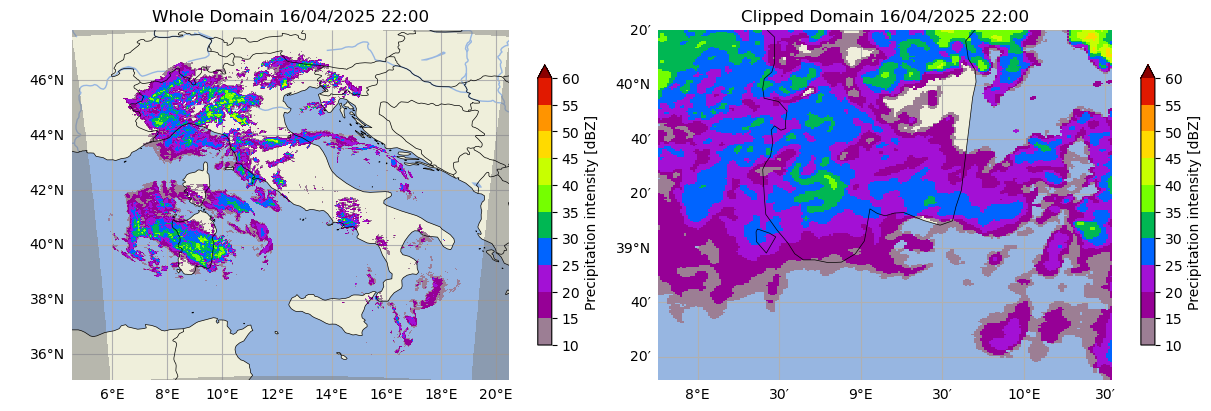

In [7]:
map_kwargs = {"drawlonlatlines": True}
fig = plt.figure(figsize=(12, 4), layout="constrained")
# turn off axis, because it will be overwritten in plot_precip_field
ax = fig.add_subplot(121); ax.axis("off")
plot_precip_field(
    dbz_cp[7, :, :],
    ptype="intensity",
    geodata=metadata_cp_dbz,
    colorscale="pysteps",
    colorbar=True,
    title =f"Whole Domain {metadata_cp_dbz['timestamps'][7].strftime('%d/%m/%Y %H:%M')}",
    map_kwargs=map_kwargs,
    units="dBZ",
    ax=ax);
ax = fig.add_subplot(122); ax.axis("off")
plot_precip_field(
    dbz_cp_clipped[7,:,:],
    ptype="intensity",
    geodata=metadata_cp_dbz_clipped,
    colorscale="pysteps",
    colorbar=True,
    title =f"Clipped Domain {metadata_cp_dbz_clipped['timestamps'][7].strftime('%d/%m/%Y %H:%M')}",
    map_kwargs=map_kwargs,
    units="dBZ",
    ax=ax);

# Conversion to rain rate (mm/h)

In [8]:
from pysteps.utils import conversion
R_cp, metadata_cp_R= conversion.to_rainrate(dbz_cp_clipped, metadata_cp_dbz_clipped)

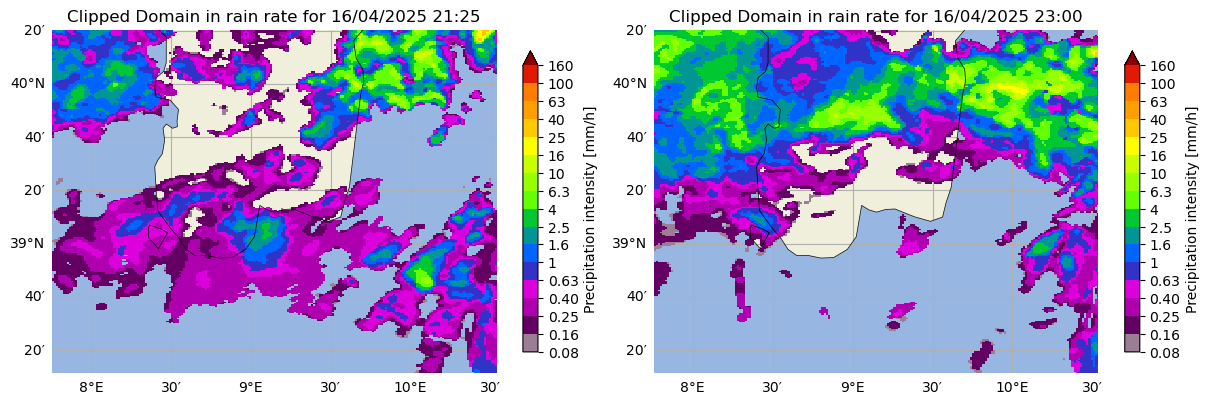

In [9]:
fig = plt.figure(figsize=(12,4), layout="constrained")
# turn off axis, because it will be overwritten in plot_precip_field
ax = fig.add_subplot(121); ax.axis("off")
plot_precip_field(
    R_cp[0, :, :],
    ptype="intensity",
    geodata=metadata_cp_R,
    colorscale="pysteps",
    colorbar=True,
    title =f"Clipped Domain in rain rate for {metadata_cp_R['timestamps'][0].strftime('%d/%m/%Y %H:%M')}",
    map_kwargs=map_kwargs,
    units="mm/h",
    ax=ax);
ax = fig.add_subplot(122); ax.axis("off")
plot_precip_field(
    R_cp[-1, :, :],
    ptype="intensity",
    geodata=metadata_cp_R,
    colorscale="pysteps",
    colorbar=True,
    title =f"Clipped Domain in rain rate for {metadata_cp_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}",
    map_kwargs=map_kwargs,
    units="mm/h",
    ax=ax);

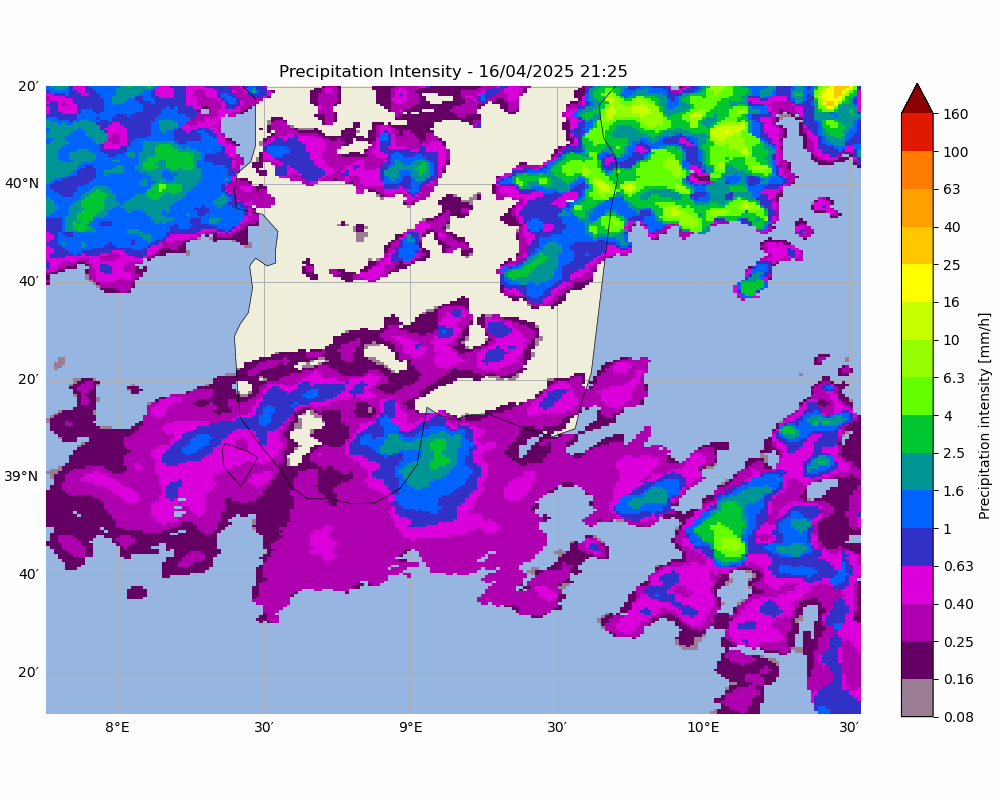

In [10]:
# Create a GIF that loops indefinitely
utility.create_gif(R_cp, metadata_cp_R,duration=5, units="mm/h", title="Precipitation Intensity",loop=True)

# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,

In [11]:
# set the fill value to -30 dBR
from pysteps.utils import transformation
dbr_cp, metadata_cp_dbr = transformation.dB_transform(R_cp, metadata_cp_R, threshold=0.01, zerovalue=-30.0)

# Set missing values with the fill value
dbr_cp[~np.isfinite(dbr_cp)] = -30

# print the metadata
pprint(metadata_cp_dbr)

{'accutime': 5,
 'cartesian_unit': 'degree',
 'institution': 'Italian Civil Protection',
 'n_timesteps': 20,
 'product': 'h5',
 'projection': 'EPSG:4326',
 'threshold': np.float64(-20.0),
 'timestamps': array([datetime.datetime(2025, 4, 16, 21, 25, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 30, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 35, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 40, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 45, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 50, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 21, 55, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 22, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 22, 5, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025, 4, 16, 22, 10, tzinfo=datetime.timezone.utc),
       datetime.datetime(2025

# Estimate the motion field 

In [12]:
# motion field using lucas kanade optical flow (dense method) with shitomasi tracking methods
from pysteps.visualization import quiver
from pysteps.motion.lucaskanade import dense_lucaskanade

V1 = dense_lucaskanade(dbr_cp[4:8],fd_method="shitomasi",verbose=True)

Computing the motion field with the Lucas-Kanade method.
--- 7 outliers detected ---
--- LK found 367 sparse vectors ---
--- 98 samples left after declustering ---
--- total time: 0.20 seconds ---


# Plot precipitation field with calculated flow motion using Lucad Kanade

<GeoAxes: title={'center': 'Dense LK motion (shitomasi) 16/04/2025 22:00'}>

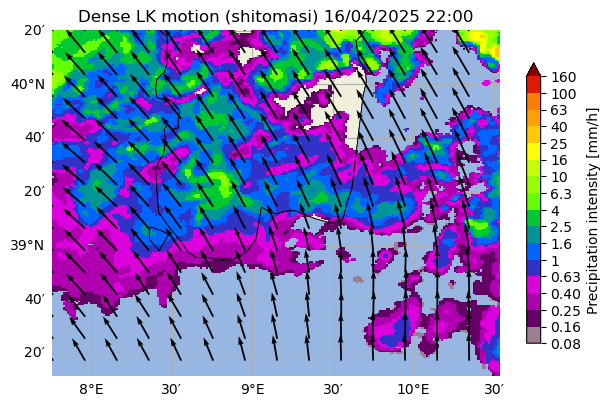

In [13]:
map_kwargs = {"drawlonlatlines": True}
fig = plt.figure(figsize=(6, 4), layout="constrained")
# turn off axis, because it will be overwritten in plot_precip_field
ax = fig.add_subplot(111); ax.axis("off")
plot_precip_field(
    R_cp[7, :, :],
    ptype="intensity",
    geodata=metadata_cp_R,
    colorscale="pysteps",
    colorbar= True,
    title =f"Dense LK motion (shitomasi) {metadata_cp_R['timestamps'][7].strftime('%d/%m/%Y %H:%M')}",
    map_kwargs=map_kwargs,
    units="mm/h",
    ax=ax);
quiver(V1, geodata=metadata_cp_R,step=15,quiver_kwargs={"scale": 80},ax=ax) 

# Comparison among different Optical Flow methods
Here we estimate different advection fields from a radar image sequence. This is the first step of all nowcasting methods currently implemented in pysteps.  We will use three different methods: Lucas-Kanade, VET and DARTS and see the differences in flow motion calculation

Optical flow computation with LK took 0.189 seconds
Optical flow computation with VET took 3.371 seconds
Optical flow computation with DARTS took 1.341 seconds


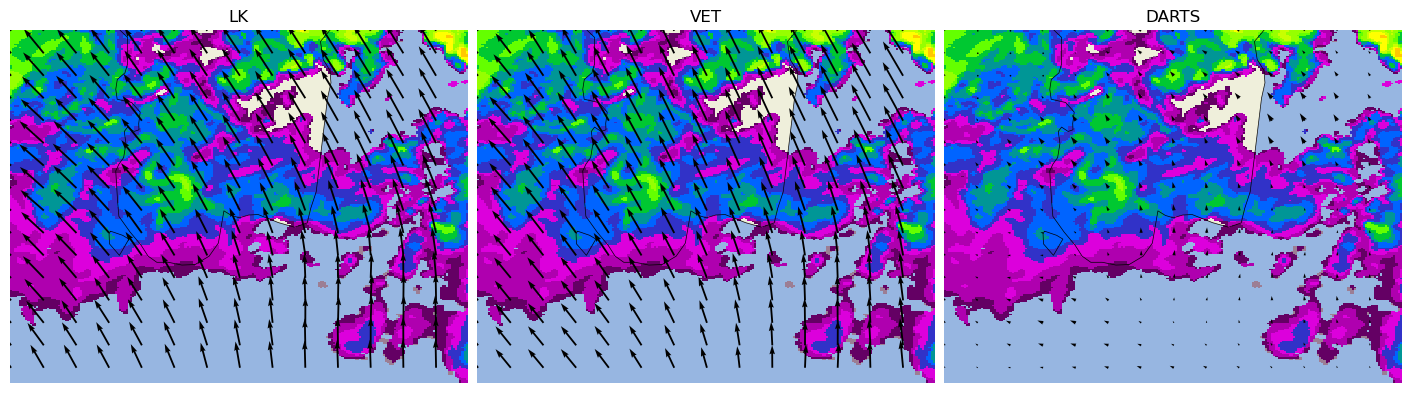

In [14]:
import time
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pysteps import motion
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field, quiver

methods = ["LK", "VET", "DARTS"]
fig = plt.figure(figsize=(14, 4), layout="constrained")


for i, method in enumerate(methods):
    # Use get_method to get a callable function for the chosen method
    oflow = motion.get_method(method)
    starttime = time.time()
    if method == "LK":
        # Use 4 most recent precipitation fields for Lucas-Kanade
        # Disable printing with verbose=False
        advection = oflow(dbr_cp[4:8], verbose=False)
    elif method == "VET":
        # VET takes two or three input fields
        advection = oflow(dbr_cp[5:8], verbose=False)
    elif method == "DARTS":
        # Use 8 most recent precipitation fields  for DARTS that
        advection = oflow(dbr_cp[0:8], verbose=False)
    print(f"Optical flow computation with {method} took {time.time() - starttime:.03f} seconds")
    ax = fig.add_subplot(131 + i); ax.axis("off")
    plot_precip_field(R_cp[7, :, :], geodata=metadata_cp_R, title=method, ax=ax, colorbar=False)
    quiver(advection, geodata=metadata_cp_R, step=15, quiver_kwargs={"scale": 80})
plt.show()

# Deterministic nowcast with semilagrangian extrapolation

In [15]:
# Extrapolate the last radar observation
n_leadtimes=12
from pysteps.extrapolation.semilagrangian import extrapolate
starttime = time.time()
R_f_sl = extrapolate(dbr_cp[7, :, :], 
                     V1, 
                     n_leadtimes,allow_nonfinite_values=True)
print(f"Extrapolation Nowcast computation with took {time.time() - starttime:.03f} seconds")
# Back-transform to rain rate
R_f_sl = transformation.dB_transform(R_f_sl,threshold=metadata_cp_dbr['threshold'], inverse=True)[0]

Extrapolation Nowcast computation with took 0.160 seconds


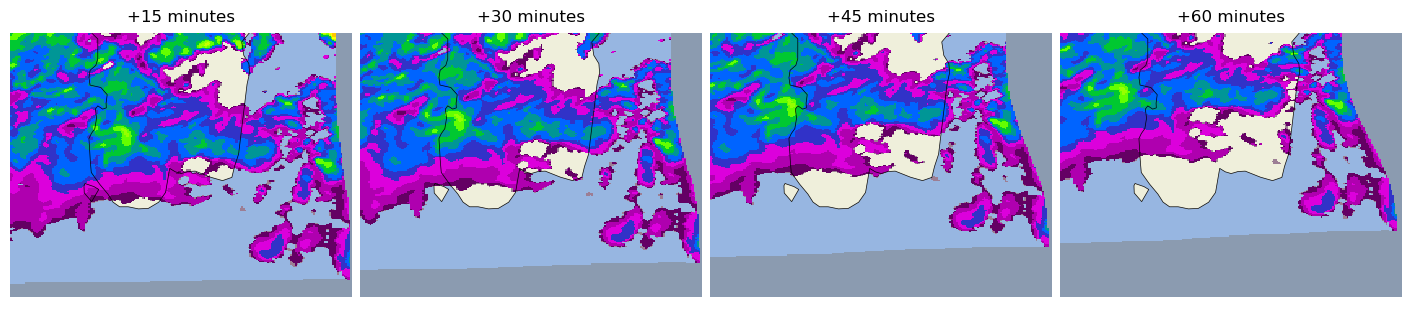

In [16]:
fig = plt.figure(figsize=(14, 3), layout="constrained")
# movement of precipitation along a nonlinear advection field.
for i in range(4):
    ax = fig.add_subplot(1, 4, 1 + i); ax.axis("off")
    plot_precip_field(R_f_sl[2+(i*3)], geodata=metadata_cp_R, colorbar=False, ax=ax)
    ax.set_title(f"+{(i + 1) * 15} minutes")
plt.show()

# Deterministic nowcast with Eulerian persistence

In [17]:
from pysteps import io, nowcasts, rcparams
# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("extrapolation")
starttime = time.time()
R_f_el = extrapolate(dbr_cp[7, :, :], 
                     V1, 
                     n_leadtimes,
                     extrap_method="eulerian")
print(f"Persistence Nowcast computation with took {time.time() - starttime:.03f} seconds")
# Back-transform to rain rate
R_f_el= transformation.dB_transform(R_f_el,threshold=metadata_cp_dbr['threshold'],inverse=True)[0]

Persistence Nowcast computation with took 0.002 seconds


# Deterministic nowcast with SPROG

In [31]:
# Set nowcast parameters
n_ens_members = 20
n_leadtimes = num_next_files
seed = 24
# The S-PROG nowcast
sprog = nowcasts.get_method("sprog")
starttime = time.time()
# takes last 4 frames as input 0,1,2,3 
R_f_sp = sprog(
    dbr_cp[4:8, :, :],
    V1,
    n_leadtimes,
    n_cascade_levels=6,
    R_thr=-30.0
)
print(f"SPROG Nowcast computation with took {time.time() - starttime:.03f} seconds")
# Back-transform to rain rate
R_f_sp = transformation.dB_transform(R_f_sp,threshold=metadata_cp_dbr['threshold'], inverse=True)[0]

Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 236x210

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -30.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.992644      | 0.967079      |
-----------------------------------------
| 2     | 0.967820      | 0.892616      |
-----------------------------------------
| 3     | 0.880230      | 0.688035      |
---------------------

# Deterministic nowcast with ANVIL

In [32]:
anvil = nowcasts.get_method("anvil")
starttime = time.time()
R_f_A =  anvil(R_cp[4:8,:,:], 
               V1, 
               n_leadtimes, 
               ar_window_radius=25, 
               ar_order=2)
print(f"ANVIL Nowcast computation with took {time.time() - starttime:.03f} seconds")

Computing ANVIL nowcast
-----------------------

Inputs
------
input dimensions: 236x210

Methods
-------
extrapolation:   semilagrangian
FFT:             numpy

Parameters
----------
number of time steps:        12
parallel threads:            1
number of cascade levels:    8
order of the ARI(p,1) model: 2
ARI(p,1) window radius:      25
R(VIL) window radius:        3
Starting nowcast computation.
Computing nowcast for time step 1... done.
Computing nowcast for time step 2... done.
Computing nowcast for time step 3... done.
Computing nowcast for time step 4... done.
Computing nowcast for time step 5... done.
Computing nowcast for time step 6... done.
Computing nowcast for time step 7... done.
Computing nowcast for time step 8... done.
Computing nowcast for time step 9... done.
Computing nowcast for time step 10... done.
Computing nowcast for time step 11... done.
Computing nowcast for time step 12... done.
ANVIL Nowcast computation with took 0.897 seconds


# Plot all the nowcasting frames

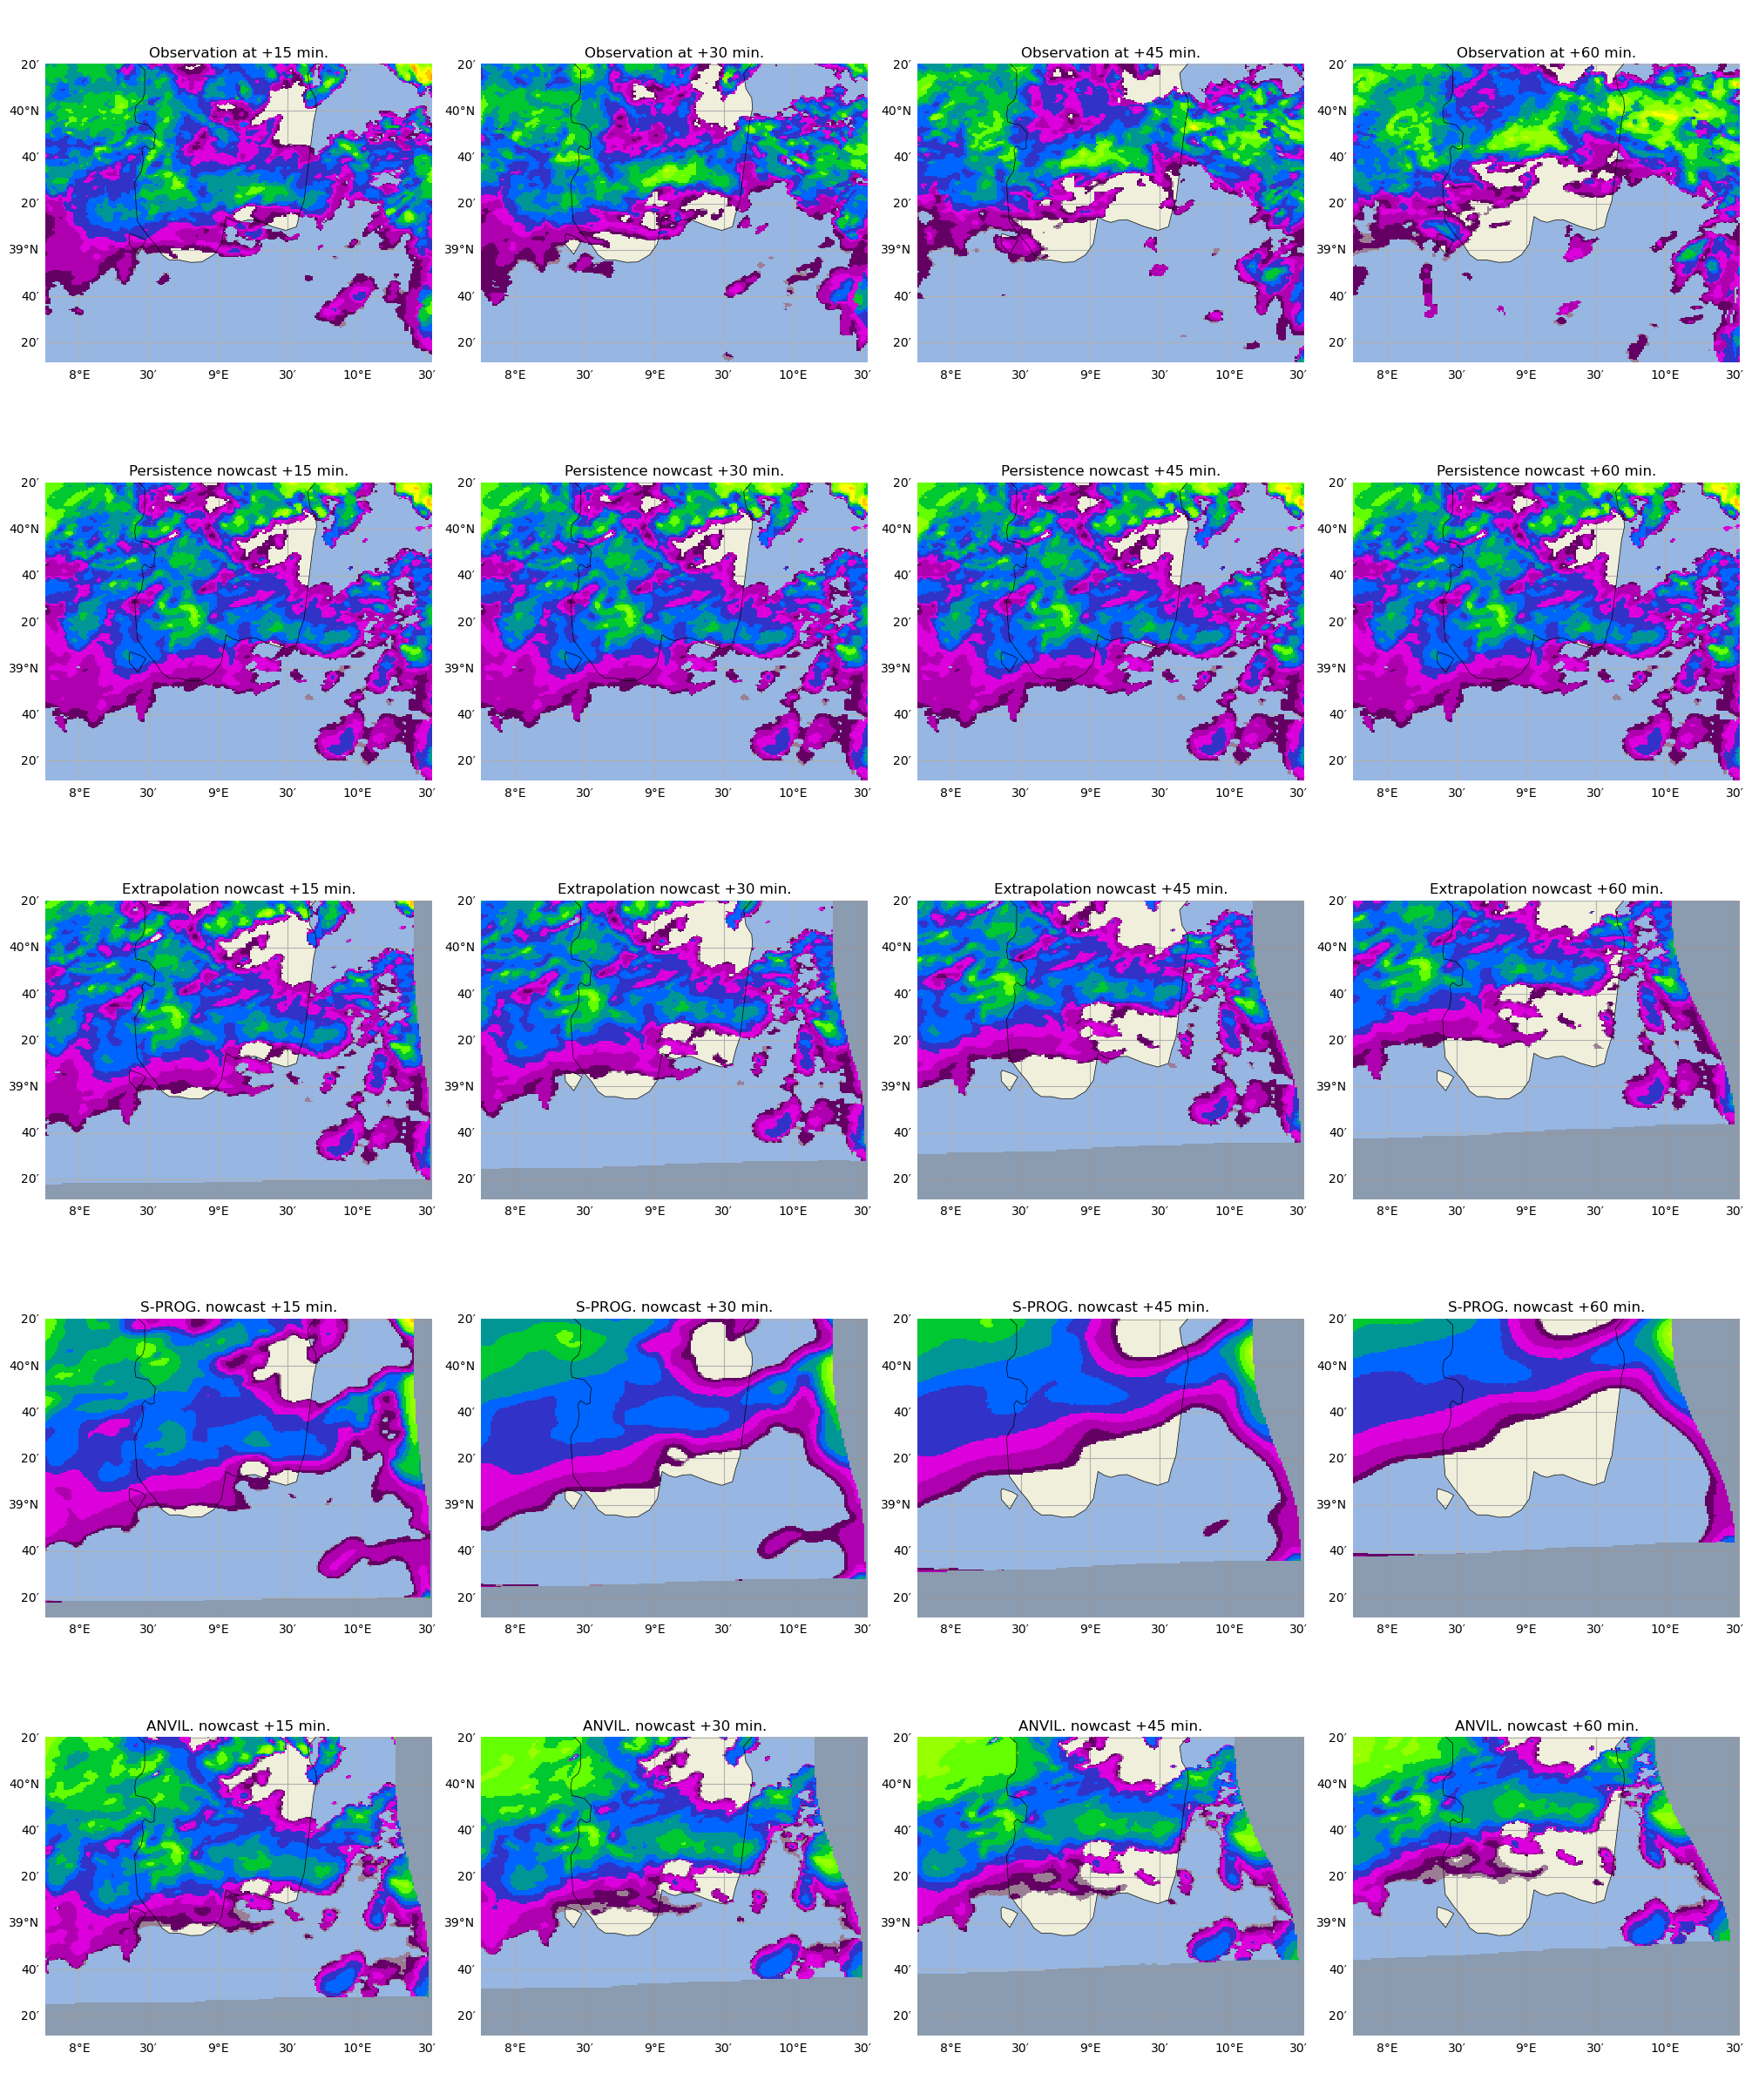

In [33]:
fig = plt.figure(figsize=(20,24), layout="constrained")
map_kwargs = {"drawlonlatlines": True}

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(5, 4, 1 + i); ax.axis("off")
    plot_precip_field(
        R_cp[10+(i*3)],
        geodata=metadata_cp_R,
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Observation at +{(j + 1) * 15} min."
        )

# We'll plot the nowcast for four lead times
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(5, 4, 5 + i); ax.axis("off")
    plot_precip_field(
        R_f_el[2+(i*3)],
        geodata=metadata_cp_R,
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Persistence nowcast +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(5, 4, 9 + i); ax.axis("off")
    plot_precip_field(
        R_f_sl[2+(i*3)],
        geodata=metadata_cp_R,
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Extrapolation nowcast +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(5, 4, 13 + i); ax.axis("off")
    plot_precip_field(
        R_f_sp[2+(i*3)],
        geodata=metadata_cp_R,
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"S-PROG. nowcast +{(j + 1) * 15} min."
        )
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(5, 4, 17 + i); ax.axis("off")
    plot_precip_field(
        R_f_A[2+(i*3)],
        geodata=metadata_cp_R,
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"ANVIL. nowcast +{(j + 1) * 15} min."
        )

# Deterministic Nowcast Verification

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pysteps import verification
# Number of lead times (12 x 5-minute steps = 60 min)
n_leadtimes = 12
# Threshold for categorical scores
thr = 0.5
# List of categorical and continuous scores to compute
cat_scores = ["POD", "FAR", "ETS"]
cont_scores = ["ME"]
# Initialize dictionaries to store the scores
cat_persist_scores = defaultdict(list)
cat_extrap_scores = defaultdict(list)
cat_sprog_scores = defaultdict(list)
cat_anvil_scores = defaultdict(list)

cont_persist_scores = defaultdict(list)
cont_extrap_scores = defaultdict(list)
cont_sprog_scores = defaultdict(list)
cont_anvil_scores = defaultdict(list)


for i in range(n_leadtimes):
    # --- Categorical scores ---
    persist_score = verification.detcatscores.det_cat_fct(R_f_el[i], R_cp[8 + i], thr=thr, scores=cat_scores)
    extrap_score = verification.detcatscores.det_cat_fct(R_f_sl[i], R_cp[8 + i], thr=thr, scores=cat_scores)
    sprog_score = verification.detcatscores.det_cat_fct(R_f_sp[i], R_cp[8 + i], thr=thr, scores=cat_scores)
    anvil_score = verification.detcatscores.det_cat_fct(R_f_A[i], R_cp[8 + i], thr=thr, scores=cat_scores)

    for name in cat_scores:
        cat_persist_scores[name].append(persist_score[name])
        cat_extrap_scores[name].append(extrap_score[name])
        cat_sprog_scores[name].append(sprog_score[name])
        cat_anvil_scores[name].append(anvil_score[name])

    # --- Continuous scores ---
    persist_score_cont = verification.detcontscores.det_cont_fct(R_f_el[i], R_cp[8 + i], scores=cont_scores)
    extrap_score_cont = verification.detcontscores.det_cont_fct(R_f_sl[i], R_cp[8 + i], scores=cont_scores)
    sprog_score_cont = verification.detcontscores.det_cont_fct(R_f_sp[i], R_cp[8 + i], scores=cont_scores)
    anvil_score_cont = verification.detcontscores.det_cont_fct(R_f_A[i], R_cp[8 + i], scores=cont_scores)

    for name in cont_scores:
        cont_persist_scores[name].append(persist_score_cont[name])
        cont_extrap_scores[name].append(extrap_score_cont[name])
        cont_sprog_scores[name].append(sprog_score_cont[name])
        cont_anvil_scores[name].append(anvil_score_cont[name])

# Plot verification scores

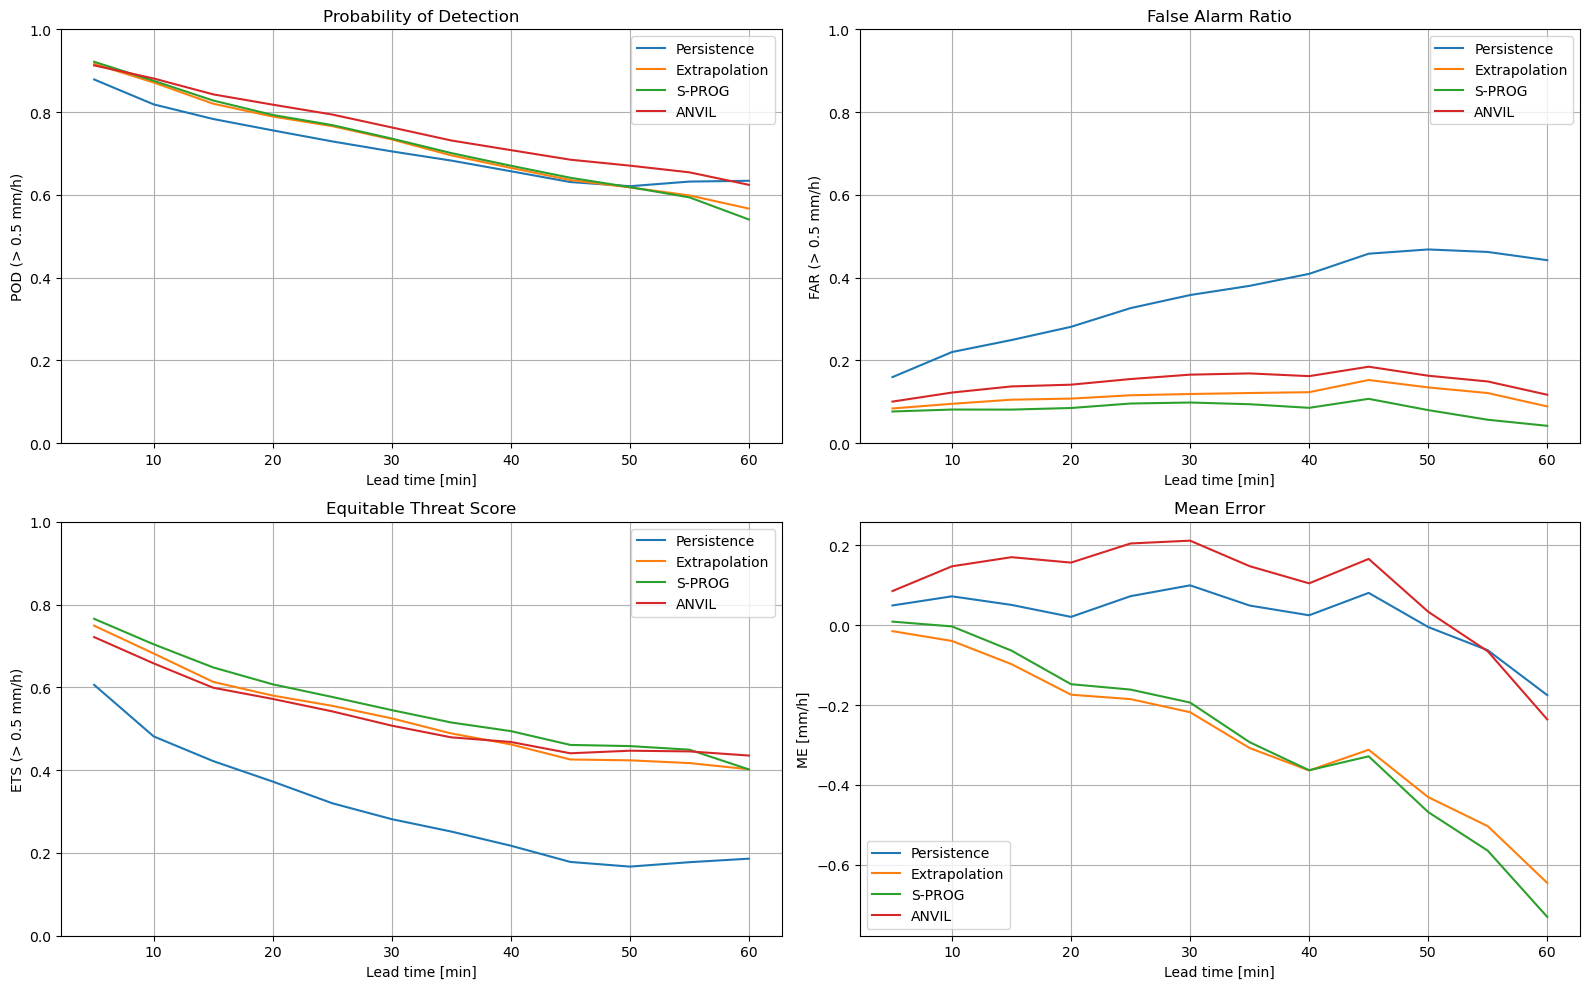

In [35]:
plt.figure(figsize=(16, 10))
x = np.arange(1, n_leadtimes + 1) * metadata_cp_R["accutime"]
# POD
plt.subplot(2, 2, 1)
plt.plot(x, cat_persist_scores["POD"], label="Persistence")
plt.plot(x, cat_extrap_scores["POD"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["POD"], label="S-PROG")
plt.plot(x, cat_anvil_scores["POD"], label="ANVIL")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"POD (> {thr} mm/h)")
plt.title("Probability of Detection")
plt.legend()
plt.grid()

# FAR
plt.subplot(2, 2, 2)
plt.plot(x, cat_persist_scores["FAR"], label="Persistence")
plt.plot(x, cat_extrap_scores["FAR"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["FAR"], label="S-PROG")
plt.plot(x, cat_anvil_scores["FAR"], label="ANVIL")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"FAR (> {thr} mm/h)")
plt.title("False Alarm Ratio")
plt.legend()
plt.grid()

# ETS
plt.subplot(2, 2, 3)
plt.plot(x, cat_persist_scores["ETS"], label="Persistence")
plt.plot(x, cat_extrap_scores["ETS"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["ETS"], label="S-PROG")
plt.plot(x, cat_anvil_scores["ETS"], label="ANVIL")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"ETS (> {thr} mm/h)")
plt.title("Equitable Threat Score")
plt.legend()
plt.grid()

# Mean Error (ME)
plt.subplot(2, 2, 4)
plt.plot(x, cont_persist_scores["ME"], label="Persistence")
plt.plot(x, cont_extrap_scores["ME"], label="Extrapolation")
plt.plot(x, cont_sprog_scores["ME"], label="S-PROG")
plt.plot(x, cont_anvil_scores["ME"], label="ANVIL")
plt.xlabel("Lead time [min]")
plt.ylabel("ME [mm/h]")
plt.title("Mean Error")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()